In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
import logging

In [11]:
data = pd.read_csv('../data/regional_univariate_data.csv')


enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')


def prepare_and_split_data(data, test_size = 0.15):
    data = data[['date', 'new_confirmed']].copy() 
    data = data.rename(columns = {'date': 'ds', 'new_confirmed':'y'})
    data = data.sort_values(by = 'ds')
    testsize = int(len(data) * (1-test_size))
    train, test = data[0:testsize], data[testsize:]
    return train, test

enc_train, enc_test = prepare_and_split_data(enc)
esc_train, esc_test = prepare_and_split_data(esc)
midatl_train, midatl_test = prepare_and_split_data(midatl)
mount_train, mount_test = prepare_and_split_data(mount)
ne_train, ne_test = prepare_and_split_data(ne)
pac_train, pac_test = prepare_and_split_data(pac)
satl_train, satl_test = prepare_and_split_data(satl)
wnc_train, wnc_test = prepare_and_split_data(wnc)
wsc_train, wsc_test = prepare_and_split_data(wsc)
print("Length enc train: ", len(enc_train))
print("Length enc test: ", len(enc_test))
enc_train.head()

Length enc train:  822
Length enc test:  146


ds    y
0  2020-01-22  0.0
1  2020-01-23  0.0
2  2020-01-24  1.0
3  2020-01-25  0.0
4  2020-01-26  0.0

In [59]:
def search_prophet(train, test, changepoints = np.logspace(-3, -1, num = 5), seasonalities = np.array([10, 100, 500]), n_changepoints_vals = np.array([15, 25, 50]), transformation = None, figsize = (15,5)):
    models = {}
    tscv = TimeSeriesSplit(n_splits=5, test_size = 14)
    best_avg_mase = 100000
    for changepoint, seasonality, n_changepoint in itertools.product(changepoints, seasonalities, n_changepoints_vals):
        all_mases = []
        for train_idx, test_idx in tscv.split(train):
            newtrain, newtest = train.iloc[train_idx], train.iloc[test_idx]
            model = Prophet(changepoint_prior_scale=changepoint, seasonality_prior_scale= seasonality, n_changepoints= n_changepoint)
            model.fit(newtrain)

            test_forecast = model.predict(newtest)

            newtest['ds'] = pd.to_datetime(newtest['ds'])
            test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

            min_test_date = newtest['ds'].min()
            max_test_date = newtest['ds'].max()
            forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
        
            y_actual = newtest['y'].values
            y_pred = forecast_filtered['yhat'].values

            # mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = newtrain['y'])
            mase = np.sqrt(mean_squared_error(y_actual, y_pred))
            all_mases.append(mase)
        
        avg_mase = np.mean(all_mases)

        if avg_mase < best_avg_mase:
            best_avg_mase = avg_mase
            best_params = (changepoint, seasonality, n_changepoint)

        models[(changepoint, seasonality, n_changepoint)] =  avg_mase

    best_model = Prophet(changepoint_prior_scale=best_params[0], seasonality_prior_scale=best_params[1], n_changepoints=best_params[2])
    best_model.fit(train)
    print('changepoint_prior_scale: ', best_params[0])
    print('seasonality_prior_scale: ', best_params[1])
    print('n_changepoints: ', best_params[2])

    train_forecast = model.predict(train)
    test_forecast = model.predict(test)
    combined_forecast = pd.concat([train_forecast, test_forecast], ignore_index=True)
    fig1 = model.plot(combined_forecast)
    fig2 = model.plot_components(combined_forecast)


    test['ds'] = pd.to_datetime(test['ds'])
    test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])
    min_test_date = test['ds'].min()
    max_test_date = test['ds'].max()
    forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
    for i in range(len(forecast_filtered['yhat'])):
        if forecast_filtered['yhat'][i] < 0:
            forecast_filtered['yhat'][i] = 0


    plt.figure(figsize = figsize)
    plt.plot(test['ds'], test['y'], label='New Cases')
    plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Predicted New Cases')
    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test['y'].values
    y_pred = forecast_filtered['yhat'].values
    for i in range(len(y_pred)):
        if y_pred[i] < 0:
            y_pred[i] = 0

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)
    mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = train['y'])

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MSE: {mse}")
    print(f"MASE: {mase}")

    test_avg = test.copy()
    test_avg['7_day_avg'] = test_avg['y'].rolling(window=7).mean()
    forecast_filtered['7_day_avg'] = forecast_filtered['yhat'].rolling(window=7).mean()

    plt.figure(figsize = figsize)
    plt.plot(test_avg['ds'], test_avg['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')
    plt.plot(forecast_filtered['ds'], forecast_filtered['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')


    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test_avg['7_day_avg'].values
    y_actual = y_actual[7:]
    y_pred = forecast_filtered['7_day_avg'].values
    y_pred = y_pred[7:]

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)

    naive = y_actual[:-1]
    naive_mae = mean_absolute_error(y_actual[1:], naive)
    mase = mae / naive_mae

    print(f"7-Day Avg MAE: {mae}")
    print(f"7-Day Avg RMSE: {rmse}")
    print(f"7-Day Avg MSE: {mse}")
    print(f"7-Day Avg MASE: {mase}")
    print(f"7-Day Avg MAPE: {mape}")

    return model, models, forecast_filtered, fig1, fig2

In [11]:
# def search_prophet(train, test, changepoints = np.logspace(-3, -1, num = 5), seasonalities = np.array([10, 100, 500]), n_changepoints_vals = np.array([15, 25, 50]), transformation = None, figsize = (15,5)):
#     models = {}

#     for changepoint, seasonality, n_changepoint in itertools.product(changepoints, seasonalities, n_changepoints_vals):
#         model = Prophet(changepoint_prior_scale=changepoint, seasonality_prior_scale= seasonality, n_changepoints= n_changepoint)
#         model.fit(train)

#         test_forecast = model.predict(test)

#         test['ds'] = pd.to_datetime(test['ds'])
#         test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

#         min_test_date = test['ds'].min()
#         max_test_date = test['ds'].max()
#         forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
        
#         y_actual = test['y'].values
#         y_pred = forecast_filtered['yhat'].values

#         # mae = mean_absolute_error(y_actual, y_pred) 
#         # rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
#         mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = train['y'])
        
#         models[changepoint] = (model, mase, test_forecast, changepoint, seasonality, n_changepoint)

#     best_changepoint = min(models, key = lambda k: models[k][1])
#     model, best_mase, test_forecast, changepoint, seasonality, n_changepoint = models[best_changepoint] 
#     print('changepoint_prior_scale: ', changepoint)
#     print('seasonality_prior_scale: ', seasonality)
#     print('n_changepoints: ', n_changepoint)

#     train_forecast = model.predict(train)

#     combined_forecast = pd.concat([train_forecast, test_forecast], ignore_index=True)

#     fig1 = model.plot(combined_forecast)
#     fig2 = model.plot_components(combined_forecast)

#     test['ds'] = pd.to_datetime(test['ds'])
#     test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

#     min_test_date = test['ds'].min()
#     max_test_date = test['ds'].max()
#     forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
#     for i in range(len(forecast_filtered['yhat'])):
#         if forecast_filtered['yhat'][i] < 0:
#             forecast_filtered['yhat'][i] = 0


#     plt.figure(figsize = figsize)
#     plt.plot(test['ds'], test['y'], label='New Cases')
#     plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Predicted New Cases')
#     # plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)
#     plt.xlabel('Date')
#     plt.ylabel('Caseload')
#     plt.title('Actual and Predicted Daily New Cases')
#     plt.legend()
#     plt.show()

#     y_actual = test['y'].values
#     y_pred = forecast_filtered['yhat'].values
#     for i in range(len(y_pred)):
#         if y_pred[i] < 0:
#             y_pred[i] = 0

#     mae = mean_absolute_error(y_actual, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
#     mse = mean_squared_error(y_actual, y_pred)

#     # Calculate MASE
#     # naive = y_actual[:-1]
#     # naive_mae = mean_absolute_error(y_actual[1:], naive)
#     # mase = mae / naive_mae
#     mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = train['y'])

#     print(f"MAE: {mae}")
#     print(f"RMSE: {rmse}")
#     print(f"MSE: {mse}")
#     print(f"MASE: {mase}")
#     # print(f"New MASE: {new_mase}")

#     test_avg = test.copy()
#     test_avg['7_day_avg'] = test_avg['y'].rolling(window=7).mean()
#     forecast_filtered['7_day_avg'] = forecast_filtered['yhat'].rolling(window=7).mean()

#     plt.figure(figsize = figsize)
#     plt.plot(test_avg['ds'], test_avg['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')
#     plt.plot(forecast_filtered['ds'], forecast_filtered['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')

# # Uncomment the following line if you want to include the prediction intervals
# # plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)

#     plt.xlabel('Date')
#     plt.ylabel('Caseload')
#     plt.title('Actual and Predicted Daily New Cases')
#     plt.legend()
#     plt.show()

#     y_actual = test_avg['7_day_avg'].values
#     y_actual = y_actual[7:]
#     y_pred = forecast_filtered['7_day_avg'].values
#     y_pred = y_pred[7:]

#     mae = mean_absolute_error(y_actual, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
#     mse = mean_squared_error(y_actual, y_pred)
#     mape = mean_absolute_percentage_error(y_actual, y_pred)

#     # Calculate MASE
#     naive = y_actual[:-1]
#     naive_mae = mean_absolute_error(y_actual[1:], naive)
#     mase = mae / naive_mae

#     print(f"7-Day Avg MAE: {mae}")
#     print(f"7-Day Avg RMSE: {rmse}")
#     print(f"7-Day Avg MSE: {mse}")
#     print(f"7-Day Avg MASE: {mase}")
#     print(f"7-Day Avg MAPE: {mape}")

#     return model, models, forecast_filtered, fig1, fig2

In [50]:
def check_hyperparams(train, test, changepoints = np.logspace(-3.5, .5, num = 30), seasonalities = np.logspace(-2, 2, num = 30), \
                      n_changepoints_vals = np.logspace(1, 2, num = 30, dtype = int), param = 'changepoint_prior_scale', metric = 'MASE'):
    param_vals = []
    mae_values = []
    rmse_values = []
    mase_values = []
    models = {}
    tscv = TimeSeriesSplit(n_splits=5, test_size = 14)
    best_avg_mase = 100000

    if param == 'changepoint_prior_scale':
        for cps in changepoints:
            all_mases = []
            all_rmses = []
            all_maes = []
            for train_idx, test_idx in tscv.split(train):
                newtrain, newtest = train.iloc[train_idx], train.iloc[test_idx]
                model = Prophet(changepoint_prior_scale=cps)
                model.fit(newtrain)

                test_forecast = model.predict(newtest)

                newtest['ds'] = pd.to_datetime(newtest['ds'])
                test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

                min_test_date = newtest['ds'].min()
                max_test_date = newtest['ds'].max()
                forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
            
                y_actual = newtest['y'].values
                y_pred = forecast_filtered['yhat'].values

                mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = newtrain['y'])
                rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
                mae = mean_absolute_error(newtest['y'], y_pred)
                all_mases.append(mase)
                all_rmses.append(rmse)
                all_maes.append(mae)
        
            mase = np.mean(all_mases)
            rmse = np.mean(all_rmses)
            mae = np.mean(all_maes)
            
            param_vals.append(cps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)
    elif param == 'seasonality_prior_scale':
        for sps in seasonalities:
            all_mases = []
            all_rmses = []
            all_maes = []
            for train_idx, test_idx in tscv.split(train):
                newtrain, newtest = train.iloc[train_idx], train.iloc[test_idx]
                model = Prophet(seasonality_prior_scale=sps)
                model.fit(newtrain)

                test_forecast = model.predict(newtest)

                newtest['ds'] = pd.to_datetime(newtest['ds'])
                test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

                min_test_date = newtest['ds'].min()
                max_test_date = newtest['ds'].max()
                forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
            
                y_actual = newtest['y'].values
                y_pred = forecast_filtered['yhat'].values

                mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = newtrain['y'])
                rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
                mae = mean_absolute_error(newtest['y'], y_pred)
                all_mases.append(mase)
                all_rmses.append(rmse)
                all_maes.append(mae)
        
            mase = np.mean(all_mases)
            rmse = np.mean(all_rmses)
            mae = np.mean(all_maes)
            
            param_vals.append(sps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)
    elif param == 'n_changepoints':
        for ncps in n_changepoints_vals:
            all_mases = []
            all_rmses = []
            all_maes = []
            for train_idx, test_idx in tscv.split(train):
                newtrain, newtest = train.iloc[train_idx], train.iloc[test_idx]
                model = Prophet(n_changepoints=round(ncps))
                model.fit(newtrain)

                test_forecast = model.predict(newtest)

                newtest['ds'] = pd.to_datetime(newtest['ds'])
                test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

                min_test_date = newtest['ds'].min()
                max_test_date = newtest['ds'].max()
                forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
            
                y_actual = newtest['y'].values
                y_pred = forecast_filtered['yhat'].values

                mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = newtrain['y'])
                rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
                mae = mean_absolute_error(newtest['y'], y_pred)
                all_mases.append(mase)
                all_rmses.append(rmse)
                all_maes.append(mae)
        
            mase = np.mean(all_mases)
            rmse = np.mean(all_rmses)
            mae = np.mean(all_maes)
            
            param_vals.append(ncps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)

    plt.figure(figsize=(10, 6))
    if metric == 'MAE':
        plt.plot(param_vals, mae_values, marker='o')
        plt.ylabel('MAE')
        sorted_indexes = np.argsort(mae_values)
        print("Lowest 5 MAEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, MAE: {mae_values[index]}")
    elif metric == 'RMSE':
        plt.plot(param_vals, rmse_values, marker='o')
        plt.ylabel('RMSE')
        sorted_indexes = np.argsort(rmse_values)
        print("Lowest 5 RMSEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, RMSE: {rmse_values[index]}")
    elif metric == 'MASE':
        plt.plot(param_vals, mase_values, marker='o')
        plt.ylabel('MASE')
        sorted_indexes = np.argsort(mase_values)
        print("Lowest 5 MASEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, MASE: {mase_values[index]}")
    plt.title('param vs metric')
    plt.xlabel('param')
    plt.xscale('log')
    plt.show()



# ENC

02:09:48 - cmdstanpy - INFO - Chain [1] start processing
02:09:48 - cmdstanpy - INFO - Chain [1] done processing
02:09:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:09:48 - cmdstanpy - INFO - Chain [1] start processing
02:09:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2519474152.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:09:50 - cmdstanpy - INFO - Chain [1] start processing
02:09:50 - cmdstanpy - INFO - Chain [1] done processing
02:09:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not p

Lowest 5 MASEs and params:
param: 0.0015475873545578891, MASE: 1.3608709337418166
param: 0.0021261123338996556, MASE: 1.3621171871362239
param: 0.0011264816923358867, MASE: 1.3723464659992746
param: 0.00292090371703225, MASE: 1.395356344753624
param: 0.0008199608244604942, MASE: 1.4287095929442624


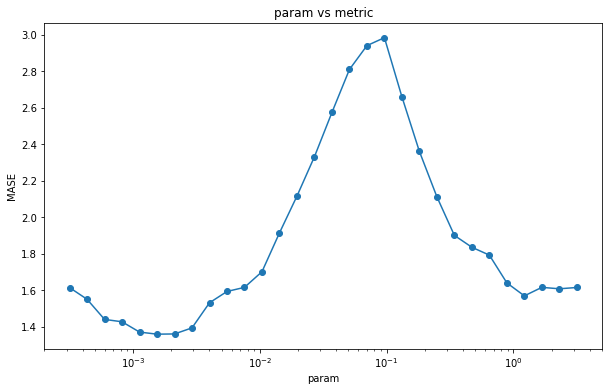

In [45]:
check_hyperparams(enc_train, enc_test, changepoints = np.logspace(-3.5, .5, num = 30))

02:11:14 - cmdstanpy - INFO - Chain [1] start processing
02:11:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2550571445.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:11:14 - cmdstanpy - INFO - Chain [1] start processing
02:11:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2550571445.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 0.17433288221999882, MASE: 2.7618001589319636
param: 5.736152510448681, MASE: 2.7630990064659473
param: 3.039195382313198, MASE: 2.7648387149830667
param: 14.873521072935118, MASE: 2.7665930272943378
param: 72.78953843983146, MASE: 2.768847331305452


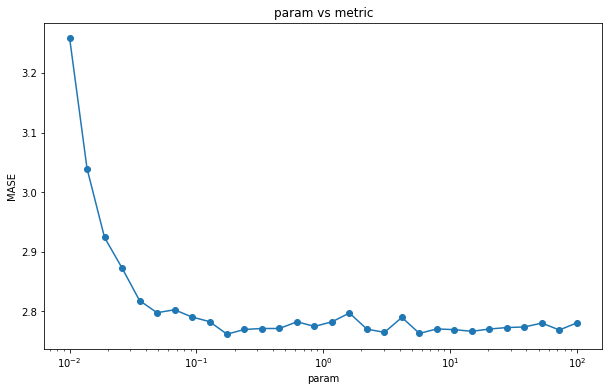

In [47]:
check_hyperparams(enc_train, enc_test, param = 'seasonality_prior_scale')

02:13:43 - cmdstanpy - INFO - Chain [1] start processing
02:13:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:13:43 - cmdstanpy - INFO - Chain [1] start processing
02:13:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 57, MASE: 2.752121382575063
param: 17, MASE: 2.752136469926389
param: 38, MASE: 2.757067776619091
param: 100, MASE: 2.7583126952669055
param: 85, MASE: 2.7586177629184947


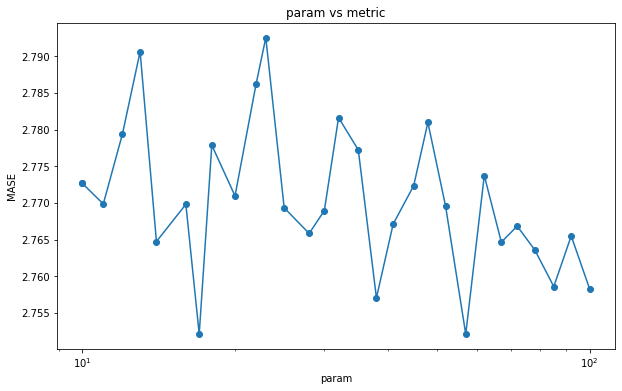

In [51]:
check_hyperparams(enc_train, enc_test, param = 'n_changepoints')

02:32:07 - cmdstanpy - INFO - Chain [1] start processing
02:32:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:32:07 - cmdstanpy - INFO - Chain [1] start processing
02:32:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

changepoint_prior_scale:  0.0011
seasonality_prior_scale:  0.17
n_changepoints:  17


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

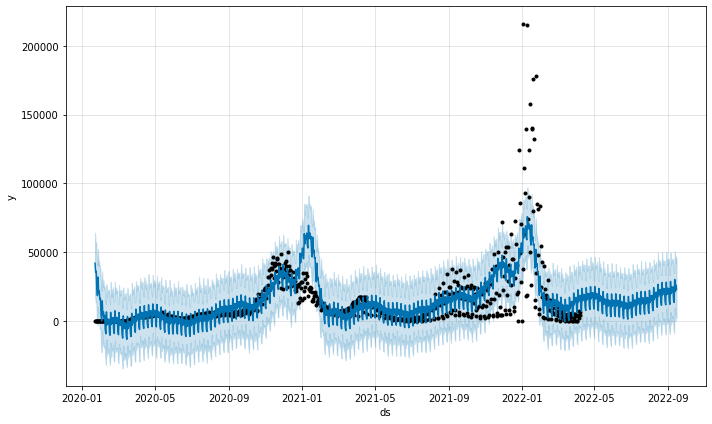

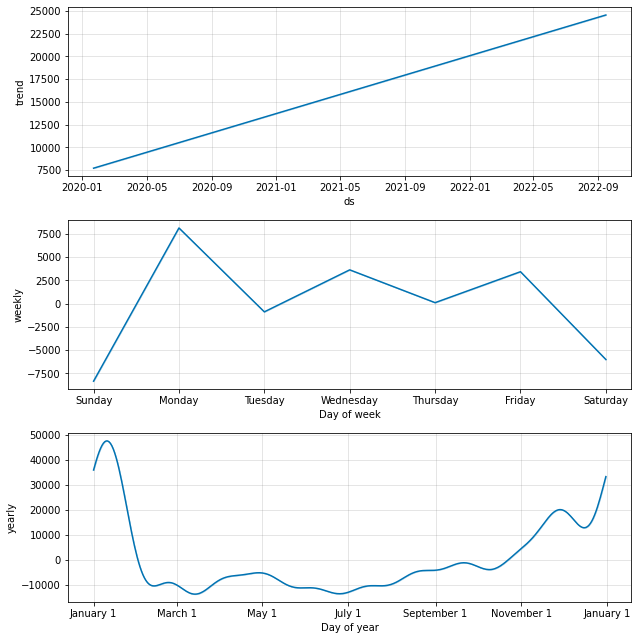

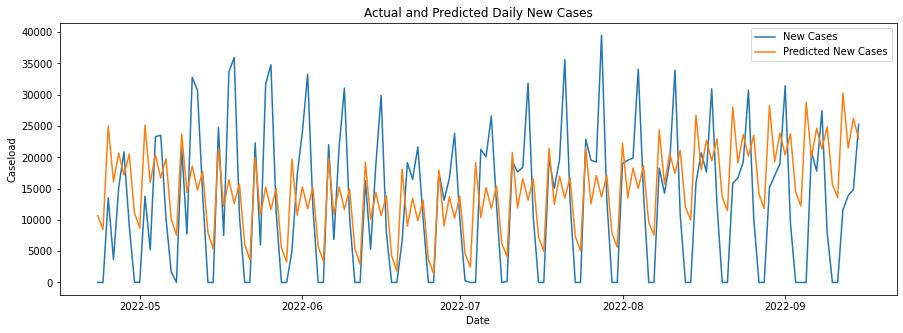

MAE: 8215.735488674662
RMSE: 10077.678718321476
MSE: 101559608.3497096
MASE: 1.0359456575369743


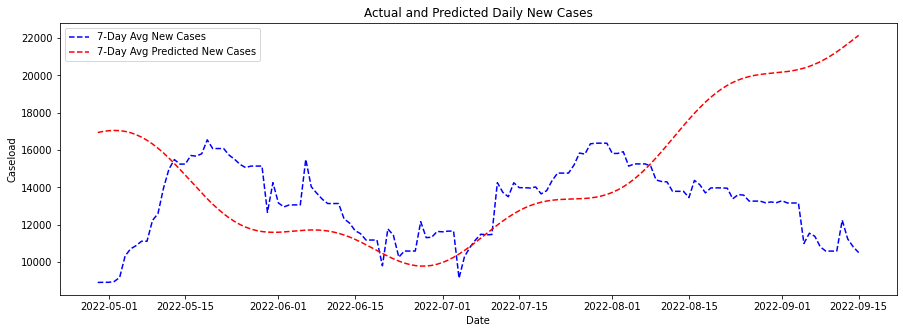

7-Day Avg MAE: 3296.419833377508
7-Day Avg RMSE: 4420.415267268608
7-Day Avg MSE: 19540071.135101393
7-Day Avg MASE: 8.038587034227662
7-Day Avg MAPE: 0.2672707648184601


In [61]:
model, models, forecast_enc, fig1, fig2 = search_prophet(enc_train, enc_test, changepoints = [.0015, .0021, .0011], seasonalities= [.17, 5.7, 15], n_changepoints_vals= [57, 17, 38])

# ESC

02:33:51 - cmdstanpy - INFO - Chain [1] start processing
02:33:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:33:51 - cmdstanpy - INFO - Chain [1] start processing
02:33:51 - cmdstanpy - INFO - Chain [1] done processing
02:33:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:33:51 - cmdstanpy - INFO - Chain [1] start processing
02:33:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: Setti

Lowest 5 MASEs and params:
param: 0.0011264816923358867, MASE: 1.3291519004933747
param: 0.000596845699512231, MASE: 1.342564601009104
param: 0.0008199608244604942, MASE: 1.3479500528369552
param: 0.0015475873545578891, MASE: 1.428522807576329
param: 3.1622776601683795, MASE: 1.53561765459586


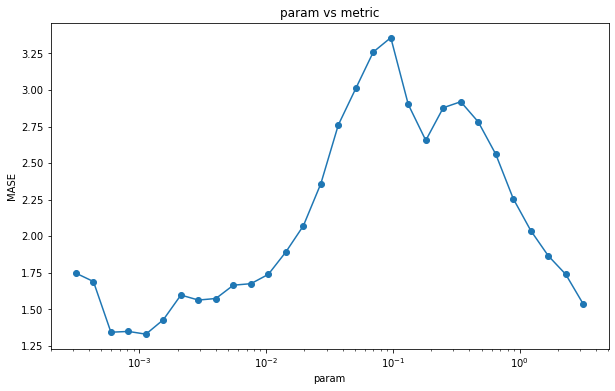

In [62]:
check_hyperparams(esc_train, esc_test)

02:34:54 - cmdstanpy - INFO - Chain [1] start processing
02:34:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:34:55 - cmdstanpy - INFO - Chain [1] start processing
02:34:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 3.039195382313198, MASE: 2.9767758552895414
param: 52.98316906283707, MASE: 2.9799139605457756
param: 100.0, MASE: 2.980189052366172
param: 1.6102620275609392, MASE: 2.983533191880143
param: 4.175318936560401, MASE: 2.9844524131599384


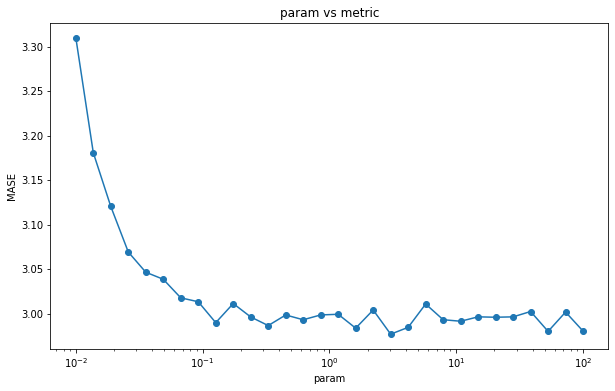

In [63]:
check_hyperparams(esc_train, esc_test, param = 'seasonality_prior_scale')

02:35:32 - cmdstanpy - INFO - Chain [1] start processing
02:35:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:35:32 - cmdstanpy - INFO - Chain [1] start processing
02:35:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 13, MASE: 2.9569069054994985
param: 11, MASE: 2.9658523731708533
param: 14, MASE: 2.9667236985201013
param: 25, MASE: 2.969981893459674
param: 17, MASE: 2.972916548744794


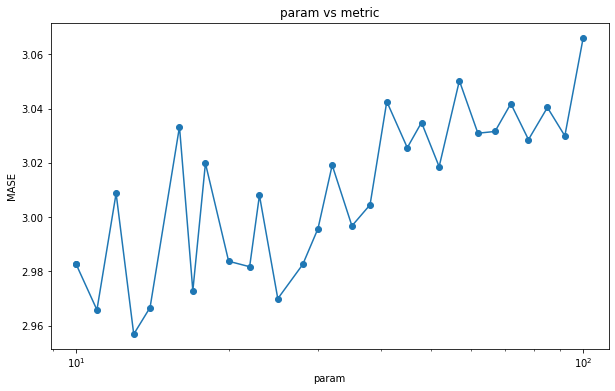

In [64]:
check_hyperparams(esc_train, esc_test, param = 'n_changepoints')

02:38:05 - cmdstanpy - INFO - Chain [1] start processing
02:38:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:38:06 - cmdstanpy - INFO - Chain [1] start processing
02:38:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

changepoint_prior_scale:  0.0006
seasonality_prior_scale:  3
n_changepoints:  11


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

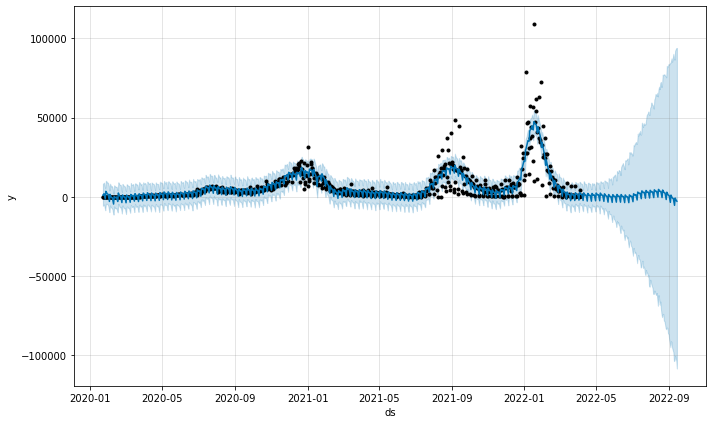

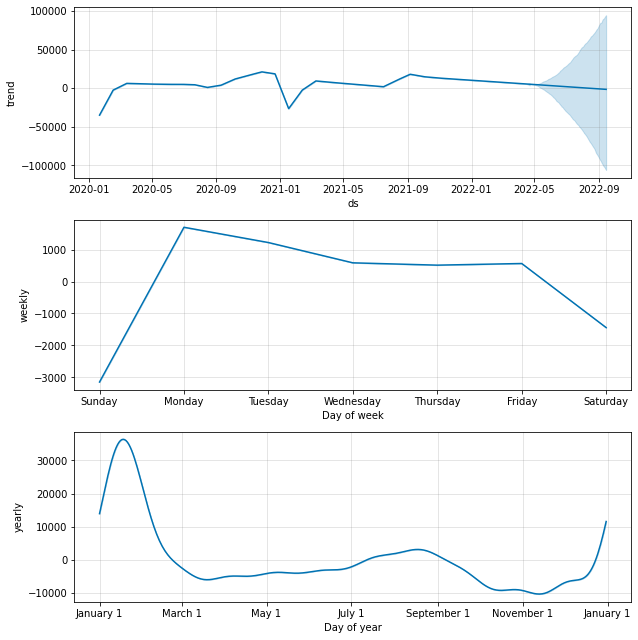

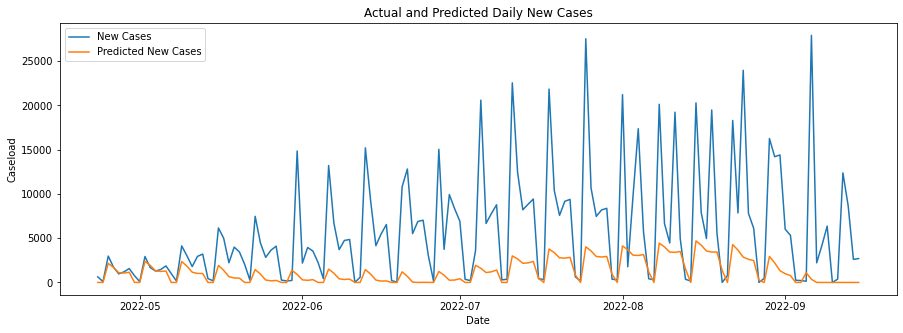

MAE: 4800.736635034735
RMSE: 7347.153976136267
MSE: 53980671.549054965
MASE: 1.448767838438181


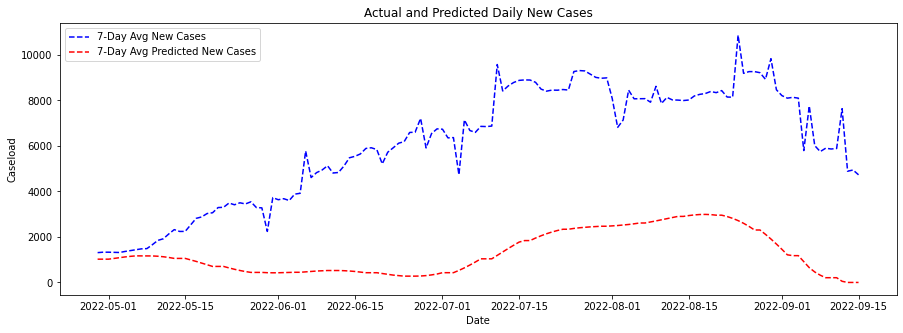

7-Day Avg MAE: 4801.759857131485
7-Day Avg RMSE: 5226.550437393386
7-Day Avg MSE: 27316829.474616997
7-Day Avg MASE: 12.497171121092064
7-Day Avg MAPE: 0.7573453201299389


In [65]:
model, models, forecast_esc, fig1, fig2 = search_prophet(esc_train, esc_test, changepoints = [.0011, .0006, .00082, 3.2], seasonalities= [3, 53, 100], n_changepoints_vals= [13, 11, 14, 25])

# MIDATL

02:40:11 - cmdstanpy - INFO - Chain [1] start processing
02:40:11 - cmdstanpy - INFO - Chain [1] done processing
02:40:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:40:12 - cmdstanpy - INFO - Chain [1] start processing
02:40:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:40:13 - cmdstanpy - INFO - Chain [1] start processing
02:40:13 - cmdstanpy - INFO - Chain [1] done processing
02:40:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not p

Lowest 5 MASEs and params:
param: 0.342359795760758, MASE: 4.16394059183093
param: 0.4703420341698635, MASE: 4.48725606398357
param: 0.646167078746697, MASE: 4.873837039746159
param: 0.8877197088985861, MASE: 4.912558213606853
param: 1.2195704601594415, MASE: 5.14211811521878


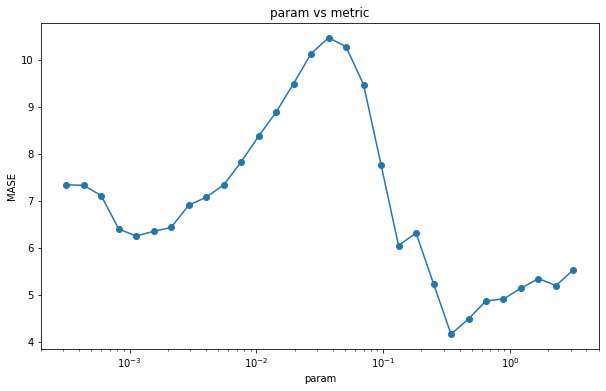

In [66]:
check_hyperparams(midatl_train, midatl_test)

02:41:26 - cmdstanpy - INFO - Chain [1] start processing
02:41:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:41:26 - cmdstanpy - INFO - Chain [1] start processing
02:41:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 4.175318936560401, MASE: 10.199143070350807
param: 5.736152510448681, MASE: 10.212030302241153
param: 72.78953843983146, MASE: 10.26145458798531
param: 20.433597178569418, MASE: 10.27719223736522
param: 14.873521072935118, MASE: 10.284021153218186


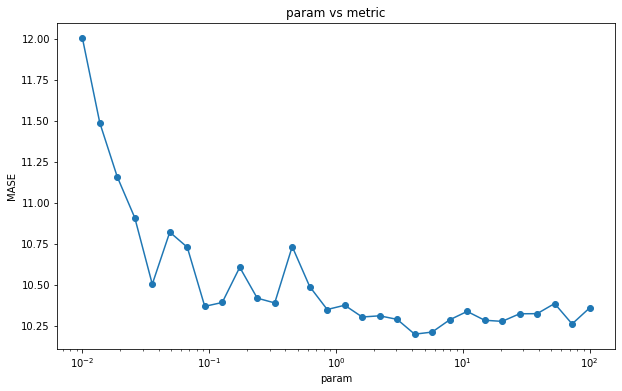

In [67]:
check_hyperparams(midatl_train, midatl_test, param = 'seasonality_prior_scale')

02:41:58 - cmdstanpy - INFO - Chain [1] start processing
02:41:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:41:58 - cmdstanpy - INFO - Chain [1] start processing
02:41:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 20, MASE: 10.160882112291002
param: 16, MASE: 10.178606177805968
param: 78, MASE: 10.18697434609608
param: 35, MASE: 10.19635774573449
param: 32, MASE: 10.225541159752957


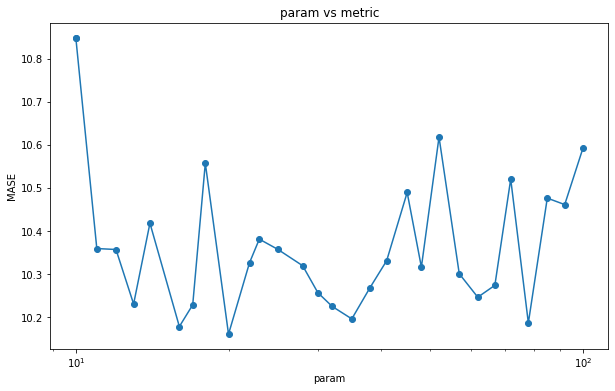

In [68]:
check_hyperparams(midatl_train, midatl_test, param = 'n_changepoints')

02:51:37 - cmdstanpy - INFO - Chain [1] start processing
02:51:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:51:37 - cmdstanpy - INFO - Chain [1] start processing
02:51:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

changepoint_prior_scale:  0.34
seasonality_prior_scale:  4.2
n_changepoints:  78


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

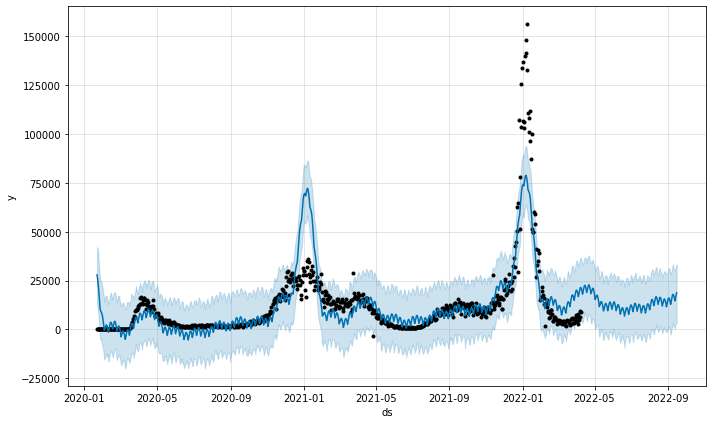

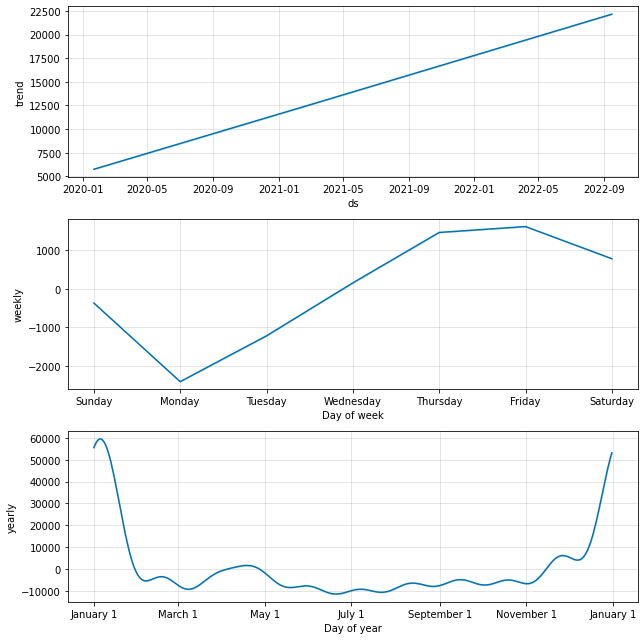

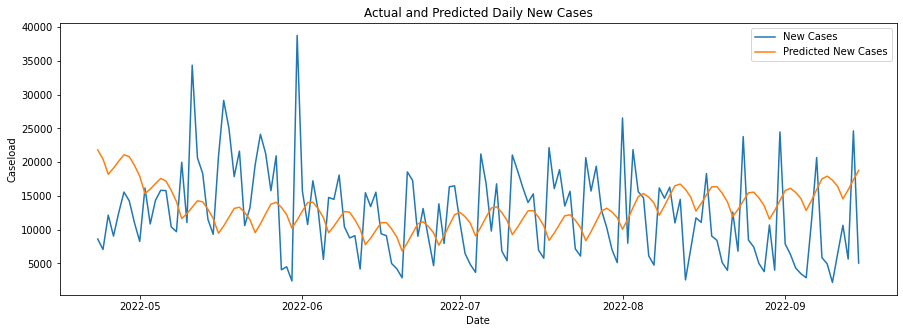

MAE: 6442.866004766318
RMSE: 7787.497783656985
MSE: 60645121.730462454
MASE: 3.0387403078343755


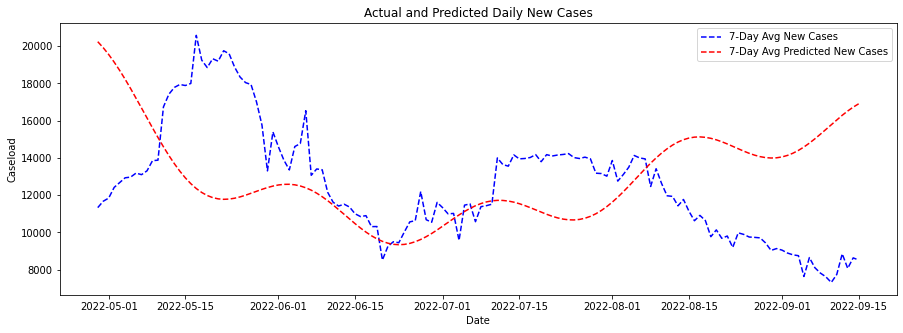

7-Day Avg MAE: 3376.456019523061
7-Day Avg RMSE: 4183.787844197836
7-Day Avg MSE: 17504080.725257583
7-Day Avg MASE: 6.241544734236196
7-Day Avg MAPE: 0.29019795452123337


In [71]:
model, models, forecast_midatl, fig1, fig2 = search_prophet(midatl_train, midatl_test, changepoints=[.34, .0015, .005], seasonalities=[4.2, 73, 0.1], n_changepoints_vals=[20, 16, 78, 35])

# MOUNTAIN

02:55:52 - cmdstanpy - INFO - Chain [1] start processing
02:55:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:55:52 - cmdstanpy - INFO - Chain [1] start processing
02:55:52 - cmdstanpy - INFO - Chain [1] done processing
02:55:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:55:52 - cmdstanpy - INFO - Chain [1] start processing
02:55:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: Setti

Lowest 5 MASEs and params:
param: 3.1622776601683795, MASE: 1.4191078227327332
param: 0.000596845699512231, MASE: 1.591446873217631
param: 0.0011264816923358867, MASE: 1.6379562999108763
param: 0.0008199608244604942, MASE: 1.6407593556513476
param: 0.0021261123338996556, MASE: 1.6443708564893798


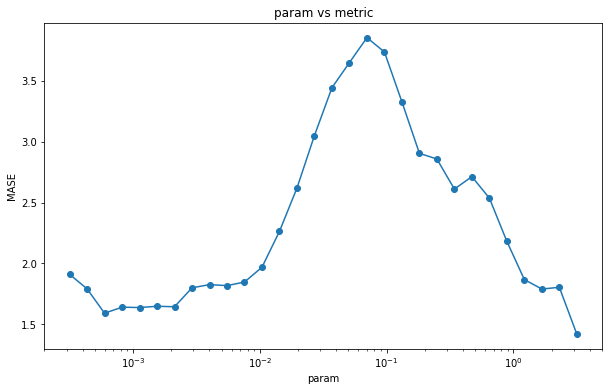

In [72]:
check_hyperparams(mount_train, mount_test)

02:57:05 - cmdstanpy - INFO - Chain [1] start processing
02:57:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:57:06 - cmdstanpy - INFO - Chain [1] start processing
02:57:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 4.175318936560401, MASE: 3.5693549150882165
param: 0.17433288221999882, MASE: 3.606690660984742
param: 0.12689610031679222, MASE: 3.6126673851684403
param: 2.212216291070448, MASE: 3.6248832059886453
param: 0.32903445623126676, MASE: 3.6252401726610195


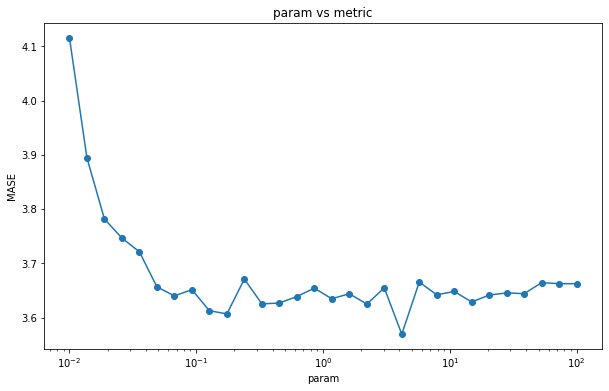

In [73]:
check_hyperparams(mount_train, mount_test, param = 'seasonality_prior_scale')

02:57:42 - cmdstanpy - INFO - Chain [1] start processing
02:57:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
02:57:42 - cmdstanpy - INFO - Chain [1] start processing
02:57:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 14, MASE: 3.5319688694493054
param: 11, MASE: 3.569041031934239
param: 17, MASE: 3.5700396098730662
param: 22, MASE: 3.576894349576358
param: 16, MASE: 3.5905747237305716


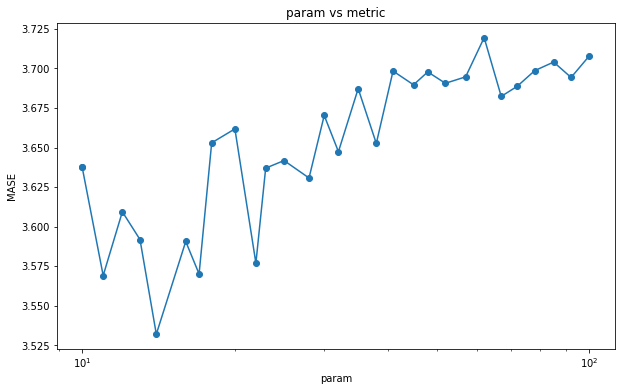

In [74]:
check_hyperparams(mount_train, mount_test, param= 'n_changepoints')

03:00:54 - cmdstanpy - INFO - Chain [1] start processing
03:00:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:00:55 - cmdstanpy - INFO - Chain [1] start processing
03:00:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

changepoint_prior_scale:  0.0006
seasonality_prior_scale:  0.13
n_changepoints:  14


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

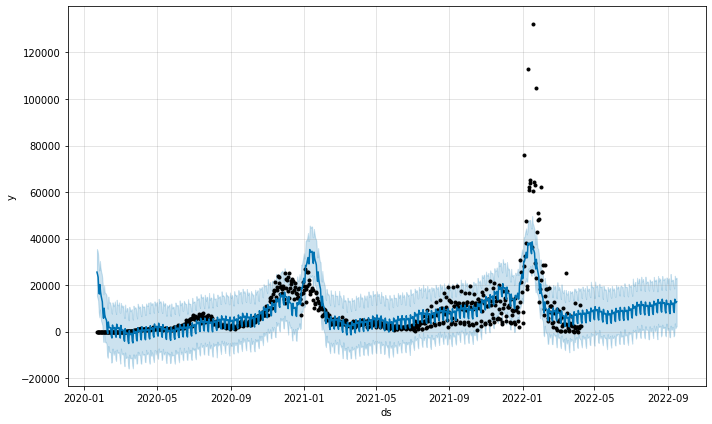

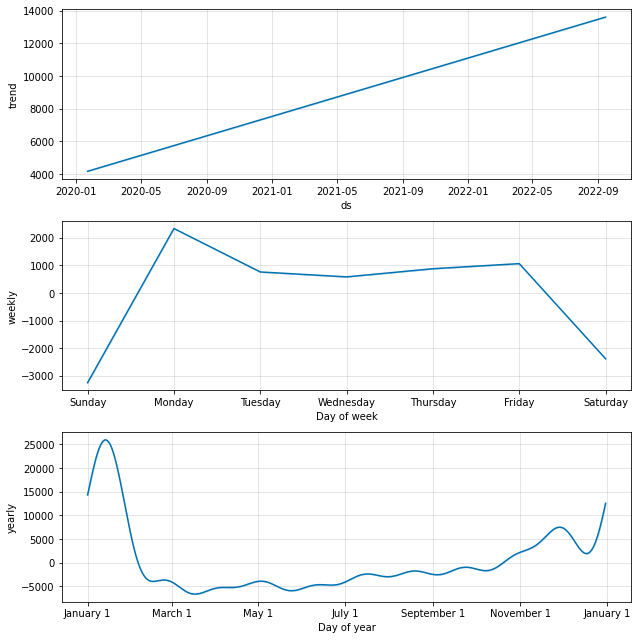

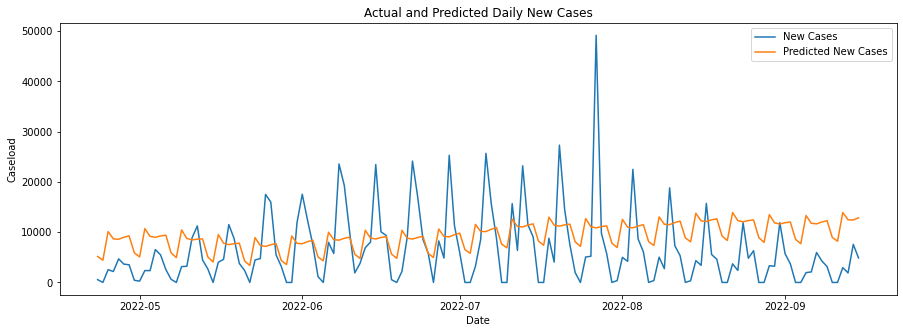

MAE: 6225.5465030344885
RMSE: 7626.346866190989
MSE: 58161166.523461126
MASE: 1.9686716747743636


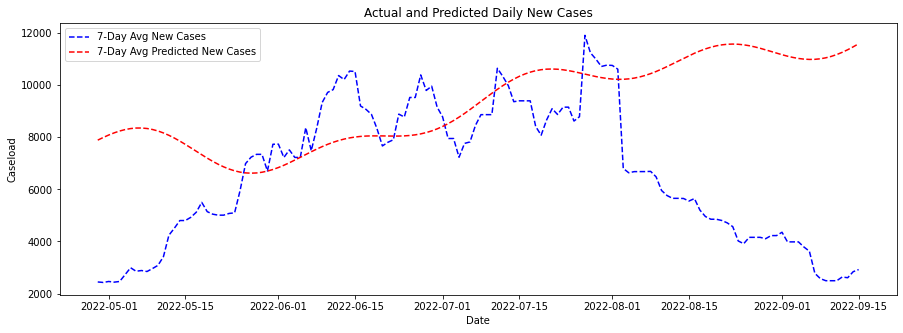

7-Day Avg MAE: 3282.497023106951
7-Day Avg RMSE: 4267.0995980007065
7-Day Avg MSE: 18208138.979257792
7-Day Avg MASE: 9.757461817581614
7-Day Avg MAPE: 0.808071730676033


In [76]:
model, models, forecast_mount, fig1, fig2 = search_prophet(mount_train, mount_test, changepoints=[3.16, 0.0006, 0.0011, 0.0021], seasonalities=[4.2, 0.17, 2.2, 0.33, 0.13], n_changepoints_vals=[14, 17, 22, 11])

# NEW ENGLAND

03:03:26 - cmdstanpy - INFO - Chain [1] start processing
03:03:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:03:26 - cmdstanpy - INFO - Chain [1] start processing
03:03:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 0.646167078746697, MASE: 1.2782068736606287
param: 0.00031622776601683794, MASE: 1.3054621287776718
param: 0.000596845699512231, MASE: 1.3267044762823177
param: 0.0008199608244604942, MASE: 1.3268041193868723
param: 0.0011264816923358867, MASE: 1.332494903956588


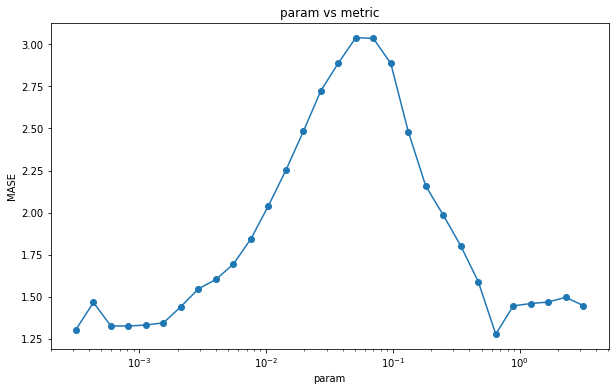

In [77]:
check_hyperparams(ne_train, ne_test)

03:04:09 - cmdstanpy - INFO - Chain [1] start processing
03:04:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:04:10 - cmdstanpy - INFO - Chain [1] start processing
03:04:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 10.82636733874054, MASE: 2.9954393773338763
param: 14.873521072935118, MASE: 3.010700170231643
param: 0.2395026619987486, MASE: 3.013735093213611
param: 28.072162039411758, MASE: 3.0158868689032357
param: 0.04893900918477494, MASE: 3.020166975200058


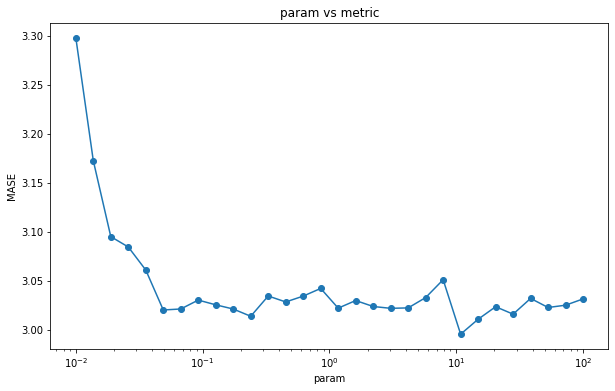

In [78]:
check_hyperparams(ne_train, ne_test, param = 'seasonality_prior_scale')

03:04:42 - cmdstanpy - INFO - Chain [1] start processing
03:04:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:04:42 - cmdstanpy - INFO - Chain [1] start processing
03:04:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 16, MASE: 2.9962446090162613
param: 30, MASE: 3.006752079279198
param: 23, MASE: 3.007091779161443
param: 17, MASE: 3.008349494807872
param: 20, MASE: 3.013463418980197


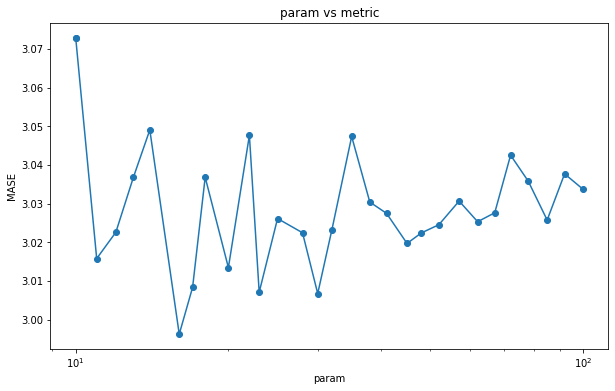

In [79]:
check_hyperparams(ne_train, ne_test, param = 'n_changepoints')

03:09:04 - cmdstanpy - INFO - Chain [1] start processing
03:09:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:09:04 - cmdstanpy - INFO - Chain [1] start processing
03:09:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

changepoint_prior_scale:  0.65
seasonality_prior_scale:  0.049
n_changepoints:  20


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

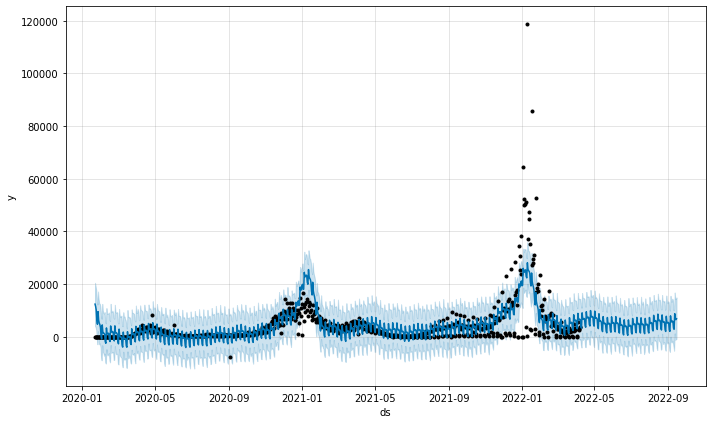

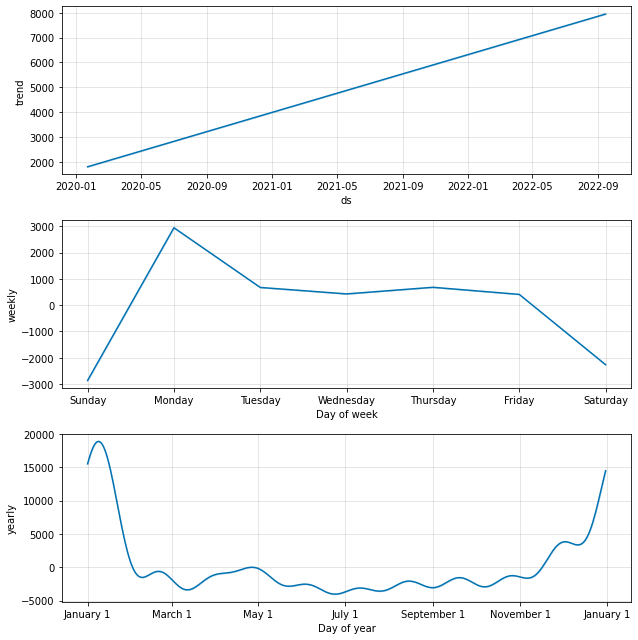

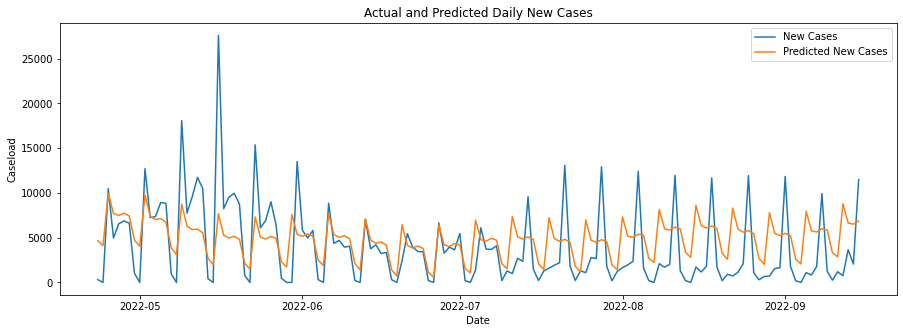

MAE: 3066.787051187428
RMSE: 4016.165510323423
MSE: 16129585.4063114
MASE: 1.2300048211903596


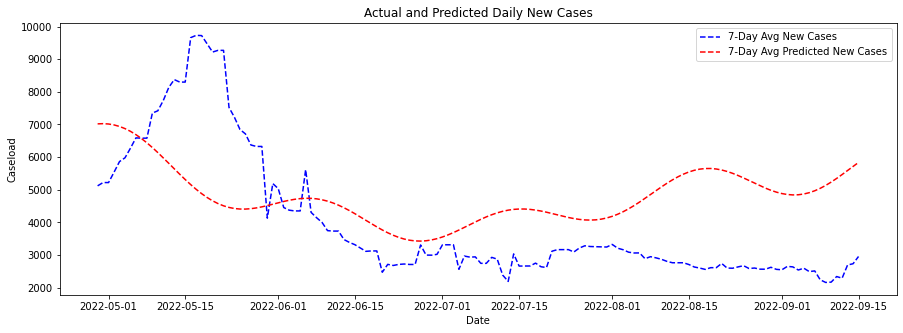

7-Day Avg MAE: 1750.3169119887395
7-Day Avg RMSE: 2076.491331763353
7-Day Avg MSE: 4311816.250888344
7-Day Avg MASE: 9.225614995013574
7-Day Avg MAPE: 0.5169701357871083


In [80]:
model, models, forecast_mount, fig1, fig2 = search_prophet(ne_train, ne_test, changepoints=[0.65, 0.00032, 0.0006, 0.00082, 0.0011], seasonalities=[11, 15, .24, 28, .049], n_changepoints_vals=[16, 30, 23, 20])

# PACIFIC

03:14:37 - cmdstanpy - INFO - Chain [1] start processing
03:14:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:14:37 - cmdstanpy - INFO - Chain [1] start processing
03:14:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 0.0008199608244604942, MASE: 1.592622485332124
param: 0.0011264816923358867, MASE: 1.5972802030733173
param: 0.000596845699512231, MASE: 1.602704757654
param: 0.0004344412298729364, MASE: 1.6137818115004983
param: 3.1622776601683795, MASE: 1.6258002861261223


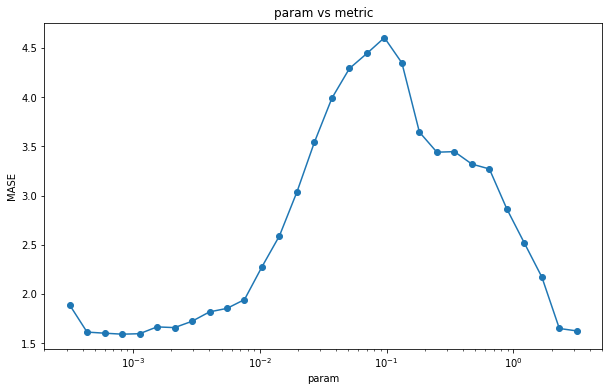

In [81]:
check_hyperparams(pac_train, pac_test)

03:15:28 - cmdstanpy - INFO - Chain [1] start processing
03:15:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:15:28 - cmdstanpy - INFO - Chain [1] start processing
03:15:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 5.736152510448681, MASE: 4.271760389454962
param: 0.2395026619987486, MASE: 4.271911546663823
param: 1.6102620275609392, MASE: 4.273114402311933
param: 0.09236708571873861, MASE: 4.278248083199673
param: 38.56620421163472, MASE: 4.2790758228125085


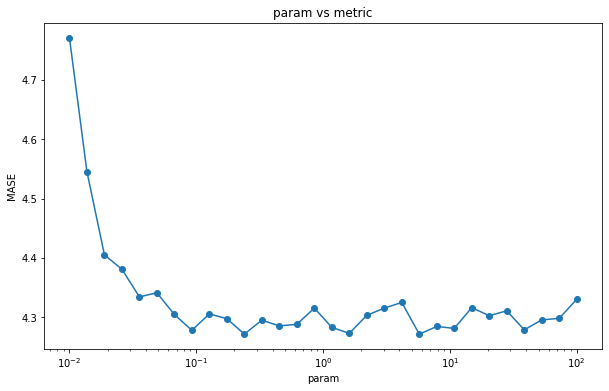

In [82]:
check_hyperparams(pac_train, pac_test, param = 'seasonality_prior_scale')

03:16:05 - cmdstanpy - INFO - Chain [1] start processing
03:16:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:16:05 - cmdstanpy - INFO - Chain [1] start processing
03:16:05 - cmdstanpy - INFO - Chain [1] done processing
03:16:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
03:16:05 - cmdstanpy - INFO - Chain [1] start processing
03:16:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: Setti

Lowest 5 MASEs and params:
param: 100, MASE: 4.250804810632205
param: 85, MASE: 4.254343428487845
param: 38, MASE: 4.262298709607267
param: 13, MASE: 4.2694360601551224
param: 30, MASE: 4.274600627152853


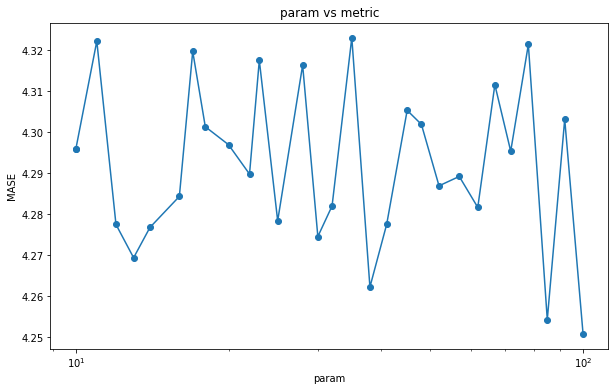

In [83]:
check_hyperparams(pac_train, pac_test, param = 'n_changepoints')

03:44:41 - cmdstanpy - INFO - Chain [1] start processing
03:44:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:44:41 - cmdstanpy - INFO - Chain [1] start processing
03:44:41 - cmdstanpy - INFO - Chain [1] done processing
03:44:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
03:44:41 - cmdstanpy - INFO - Chain [1] start processing
03:44:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWi

changepoint_prior_scale:  3.2
seasonality_prior_scale:  0.092
n_changepoints:  85


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

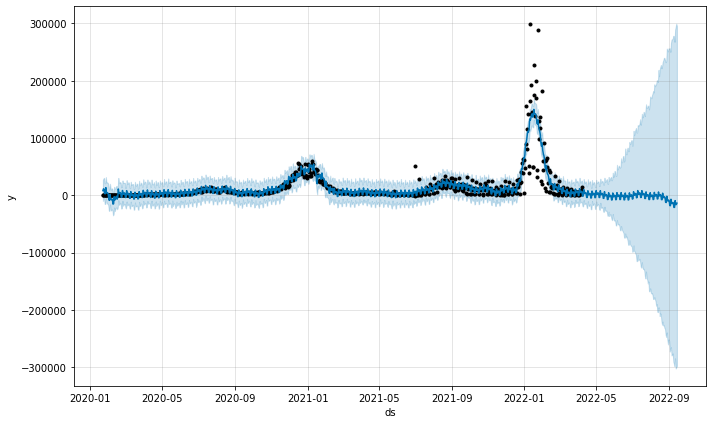

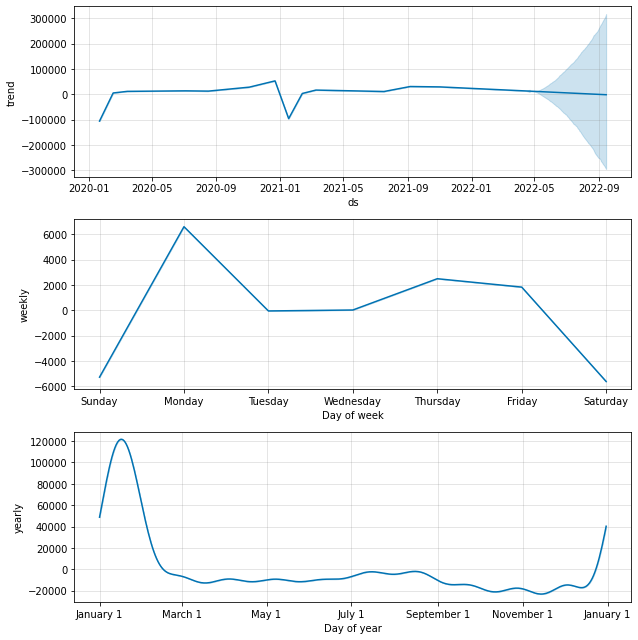

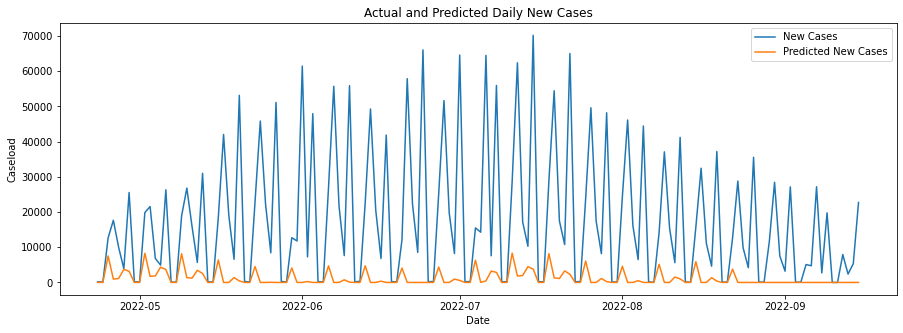

MAE: 16770.731753037595
RMSE: 25444.046955914902
MSE: 647399525.4948025
MASE: 2.510178940369973


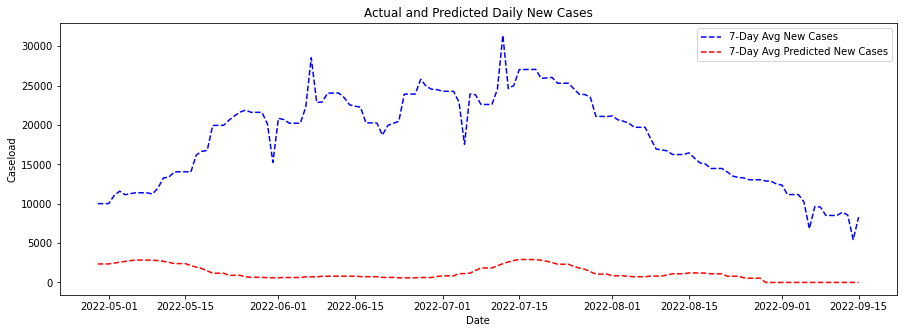

7-Day Avg MAE: 17265.730978048257
7-Day Avg RMSE: 18126.213664984763
7-Day Avg MSE: 328559621.82868034
7-Day Avg MASE: 19.937595855327103
7-Day Avg MAPE: 0.9325539710662945


In [98]:
model, models, forecast_mount, fig1, fig2 = search_prophet(pac_train, pac_test, changepoints=[0.00082, 0.05, 3.2], seasonalities=[0.24, 0.092, 10], n_changepoints_vals=[85, 38, 13, 25])

# SOUTH ATLANTIC

03:30:10 - cmdstanpy - INFO - Chain [1] start processing
03:30:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:30:10 - cmdstanpy - INFO - Chain [1] start processing
03:30:10 - cmdstanpy - INFO - Chain [1] done processing
03:30:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
03:30:10 - cmdstanpy - INFO - Chain [1] start processing
03:30:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: Setti

Lowest 5 MASEs and params:
param: 0.0011264816923358867, MASE: 1.422814510829001
param: 0.0008199608244604942, MASE: 1.448910261622529
param: 0.0015475873545578891, MASE: 1.4877822932457394
param: 0.0021261123338996556, MASE: 1.5192471763891617
param: 0.000596845699512231, MASE: 1.5400298540759525


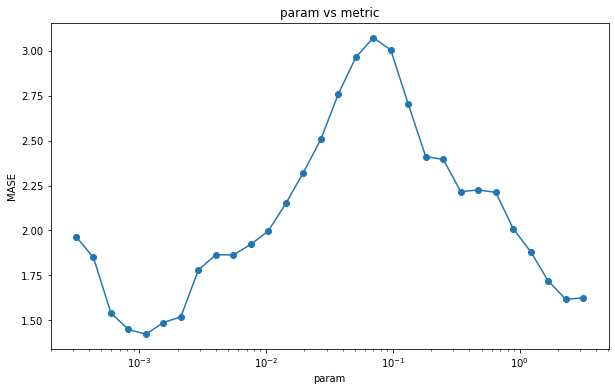

In [85]:
check_hyperparams(satl_train, satl_test)

03:31:07 - cmdstanpy - INFO - Chain [1] start processing
03:31:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:31:07 - cmdstanpy - INFO - Chain [1] start processing
03:31:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 0.8531678524172805, MASE: 2.938149088014295
param: 2.212216291070448, MASE: 2.955920219025745
param: 100.0, MASE: 2.958451302539245
param: 1.1721022975334805, MASE: 2.9629031970509807
param: 3.039195382313198, MASE: 2.964688564786333


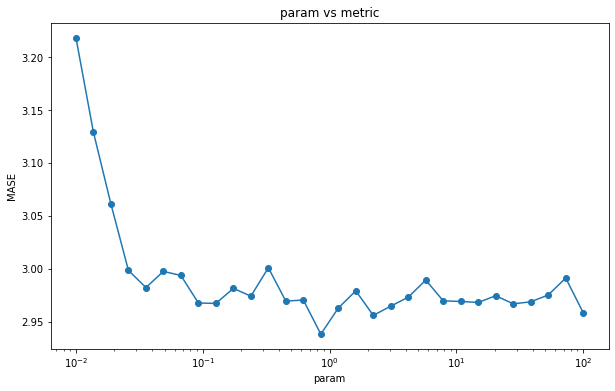

In [86]:
check_hyperparams(satl_train, satl_test, param = 'seasonality_prior_scale')

03:31:44 - cmdstanpy - INFO - Chain [1] start processing
03:31:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:31:44 - cmdstanpy - INFO - Chain [1] start processing
03:31:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 11, MASE: 2.9225939185855885
param: 12, MASE: 2.9263929596017038
param: 16, MASE: 2.9428468827238605
param: 14, MASE: 2.947460815737542
param: 13, MASE: 2.957012760778362


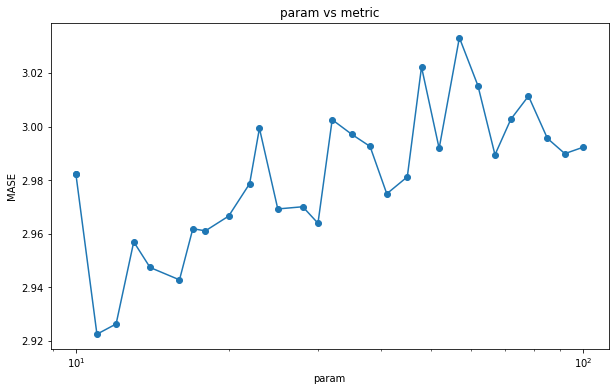

In [87]:
check_hyperparams(satl_train, satl_test, param = 'n_changepoints')

03:32:47 - cmdstanpy - INFO - Chain [1] start processing
03:32:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:32:47 - cmdstanpy - INFO - Chain [1] start processing
03:32:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

changepoint_prior_scale:  0.00082
seasonality_prior_scale:  0.85
n_changepoints:  16


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

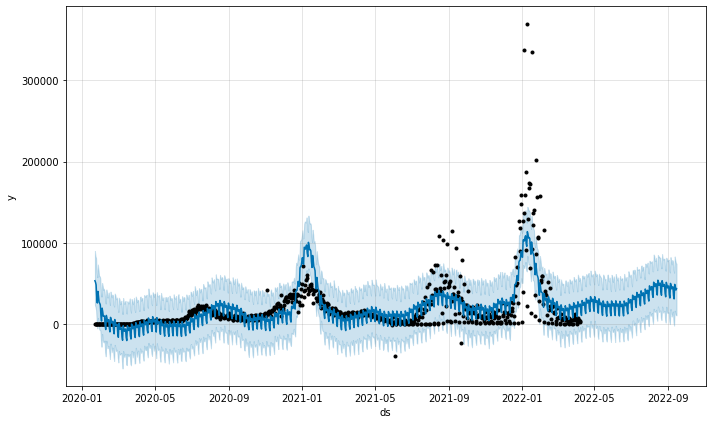

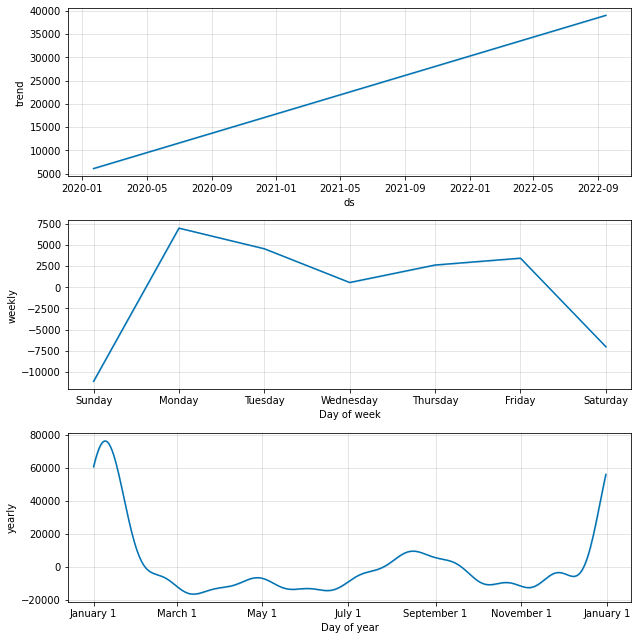

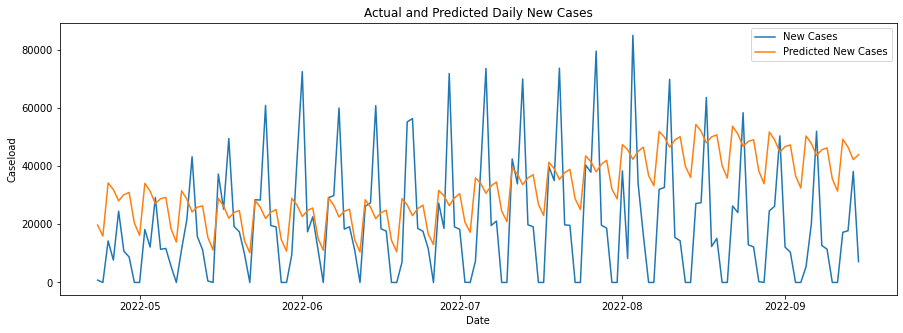

MAE: 19902.24842701538
RMSE: 23645.44028299567
MSE: 559106846.1767144
MASE: 1.909013189404231


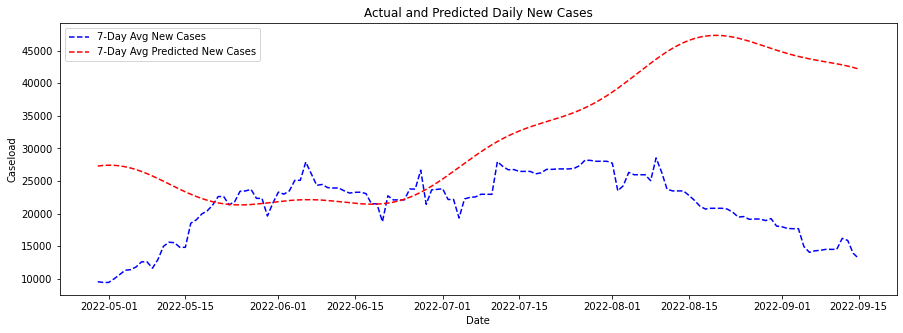

7-Day Avg MAE: 11631.244525224722
7-Day Avg RMSE: 15385.67764076848
7-Day Avg MSE: 236719076.46564314
7-Day Avg MASE: 14.583421110764087
7-Day Avg MAPE: 0.6469690306841527


In [88]:
model, models, forecast_mount, fig1, fig2 = search_prophet(satl_train, satl_test, changepoints=[0.0011, 0.00082, 0.0021], seasonalities=[0.85, 2.2, 100], n_changepoints_vals=[11, 16, 13])

# WEST NORTH CENTRAL

03:37:31 - cmdstanpy - INFO - Chain [1] start processing
03:37:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:37:31 - cmdstanpy - INFO - Chain [1] start processing
03:37:31 - cmdstanpy - INFO - Chain [1] done processing
03:37:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
03:37:31 - cmdstanpy - INFO - Chain [1] start processing
03:37:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: Setti

Lowest 5 MASEs and params:
param: 0.0011264816923358867, MASE: 1.439358911286081
param: 0.0015475873545578891, MASE: 1.4925489537527035
param: 0.000596845699512231, MASE: 1.5265624236543187
param: 0.0008199608244604942, MASE: 1.5285965961735994
param: 0.0021261123338996556, MASE: 1.5546370645413397


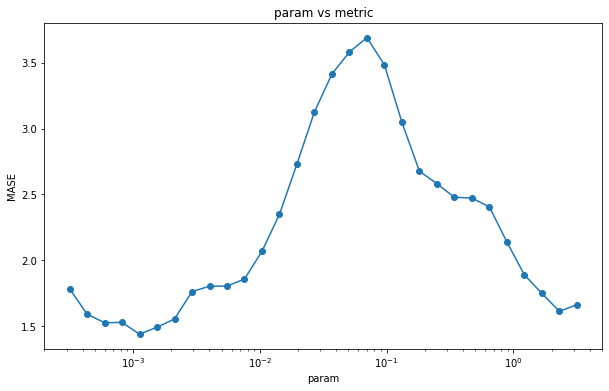

In [90]:
check_hyperparams(wnc_train, wnc_test)

03:38:28 - cmdstanpy - INFO - Chain [1] start processing
03:38:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:38:28 - cmdstanpy - INFO - Chain [1] start processing
03:38:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 3.039195382313198, MASE: 3.5470033743177027
param: 0.17433288221999882, MASE: 3.5495022732472585
param: 0.2395026619987486, MASE: 3.5521115668551233
param: 5.736152510448681, MASE: 3.5521505477029316
param: 28.072162039411758, MASE: 3.5527961636023746


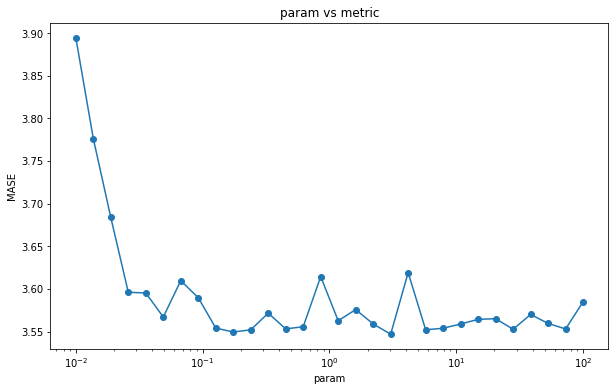

In [91]:
check_hyperparams(wnc_train, wnc_test, param = 'seasonality_prior_scale')

03:39:05 - cmdstanpy - INFO - Chain [1] start processing
03:39:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:39:05 - cmdstanpy - INFO - Chain [1] start processing
03:39:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 10, MASE: 3.543833051955116
param: 10, MASE: 3.543833051955116
param: 100, MASE: 3.550385622278155
param: 16, MASE: 3.5509663956021766
param: 22, MASE: 3.5515449476214345


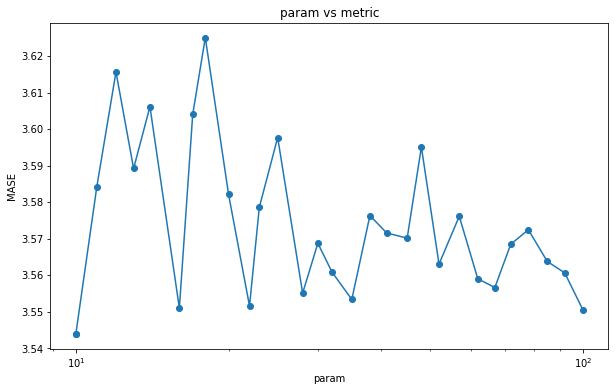

In [92]:
check_hyperparams(wnc_train, wnc_test, param = 'n_changepoints')

03:42:08 - cmdstanpy - INFO - Chain [1] start processing
03:42:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:42:08 - cmdstanpy - INFO - Chain [1] start processing
03:42:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

changepoint_prior_scale:  0.0006
seasonality_prior_scale:  0.24
n_changepoints:  10


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

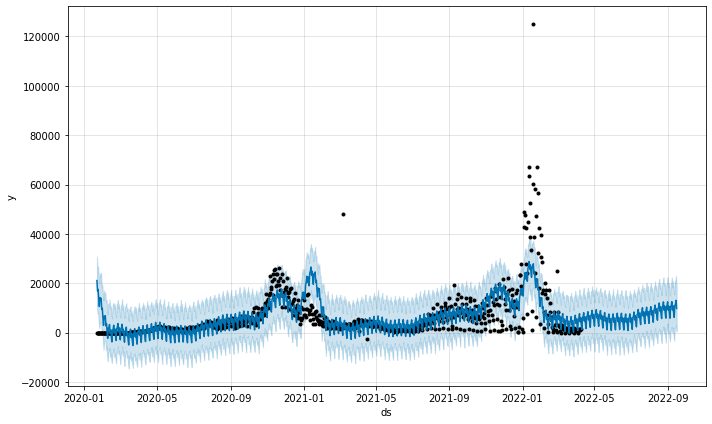

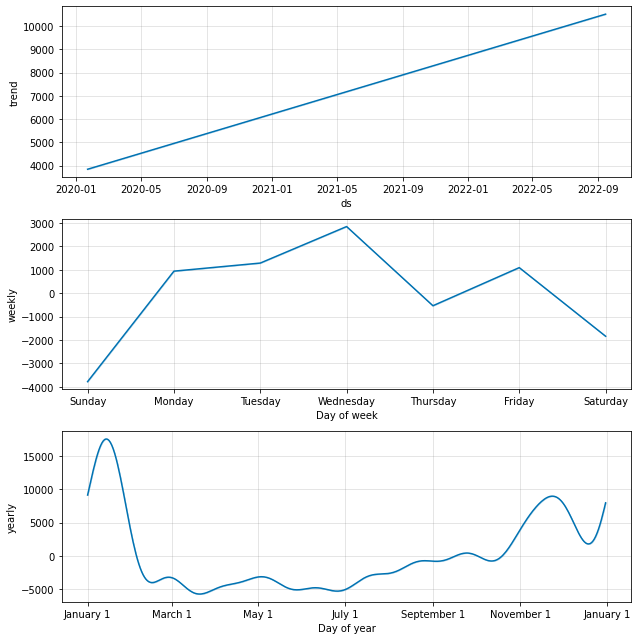

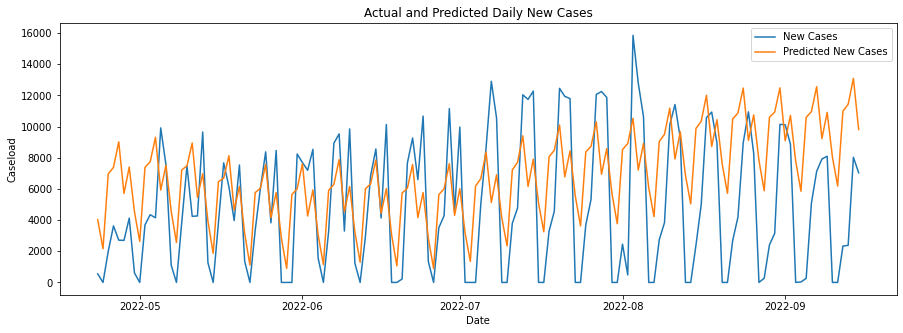

MAE: 3526.95804898916
RMSE: 4183.821813760892
MSE: 17504364.96930148
MASE: 1.1271289357089476


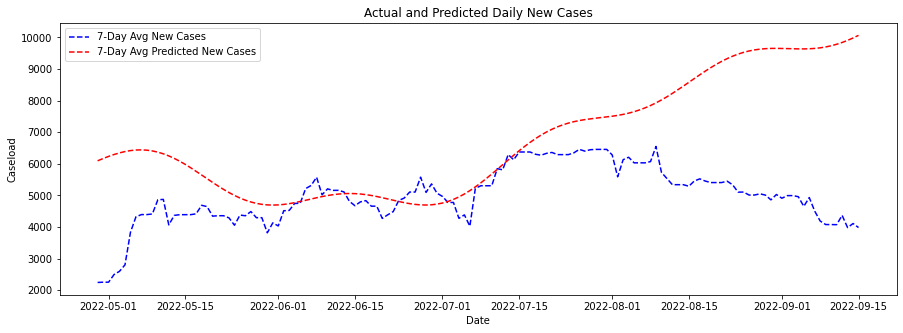

7-Day Avg MAE: 1841.0824173600872
7-Day Avg RMSE: 2565.804225662697
7-Day Avg MSE: 6583351.324428552
7-Day Avg MASE: 10.583326084345027
7-Day Avg MAPE: 0.4083740305803714


In [96]:
model, models, forecast_mount, fig1, fig2 = search_prophet(wnc_train, wnc_test, changepoints=[0.0011, 0.0006, 0.0021], seasonalities=[3.0, 0.17, .24, 28], n_changepoints_vals=[10, 16, 22, 30])

# WEST SOUTH CENTRAL

03:39:54 - cmdstanpy - INFO - Chain [1] start processing
03:39:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:39:54 - cmdstanpy - INFO - Chain [1] start processing
03:39:54 - cmdstanpy - INFO - Chain [1] done processing
03:39:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
03:39:54 - cmdstanpy - INFO - Chain [1] start processing
03:39:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:23: Setti

Lowest 5 MASEs and params:
param: 0.0015475873545578891, MASE: 1.7643539933950627
param: 0.0008199608244604942, MASE: 1.7770950079028662
param: 0.000596845699512231, MASE: 1.7981281544601753
param: 0.0011264816923358867, MASE: 1.802879943788526
param: 0.0021261123338996556, MASE: 1.8520993746063446


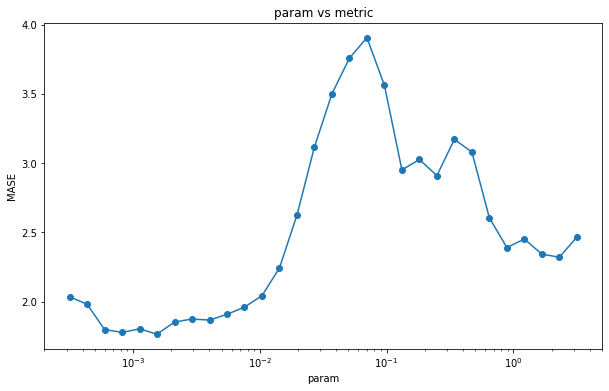

In [93]:
check_hyperparams(wsc_train, wsc_test)

03:40:55 - cmdstanpy - INFO - Chain [1] start processing
03:40:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:40:55 - cmdstanpy - INFO - Chain [1] start processing
03:40:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 20.433597178569418, MASE: 3.719587286430817
param: 5.736152510448681, MASE: 3.7212552616033276
param: 0.12689610031679222, MASE: 3.723955428181065
param: 72.78953843983146, MASE: 3.724347587345863
param: 52.98316906283707, MASE: 3.7273447705742777


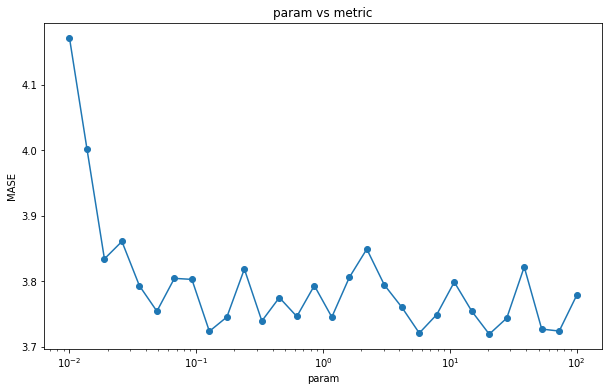

In [94]:
check_hyperparams(wsc_train, wsc_test, param = 'seasonality_prior_scale')

03:41:31 - cmdstanpy - INFO - Chain [1] start processing
03:41:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:41:31 - cmdstanpy - INFO - Chain [1] start processing
03:41:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/2270782425.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

Lowest 5 MASEs and params:
param: 11, MASE: 3.6101228312676645
param: 10, MASE: 3.6585602479753945
param: 10, MASE: 3.6585602479753945
param: 13, MASE: 3.691540783664562
param: 14, MASE: 3.6960616015987235


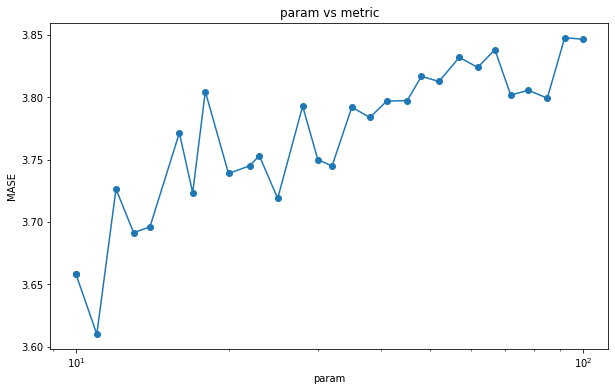

In [95]:
check_hyperparams(wsc_train, wsc_test, param = 'n_changepoints')

03:42:56 - cmdstanpy - INFO - Chain [1] start processing
03:42:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtest['ds'] = pd.to_datetime(newtest['ds'])
03:42:56 - cmdstanpy - INFO - Chain [1] start processing
03:42:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/h0/knbmnj4n297dntj6vltr94wc0000gn/T/ipykernel_4504/58478319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

changepoint_prior_scale:  0.0006
seasonality_prior_scale:  53
n_changepoints:  10


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

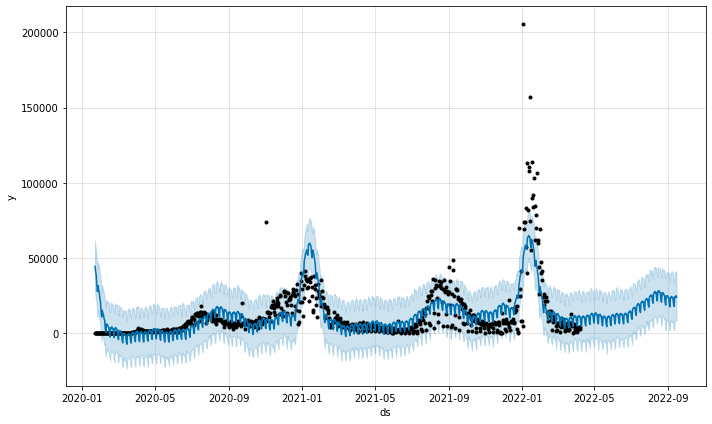

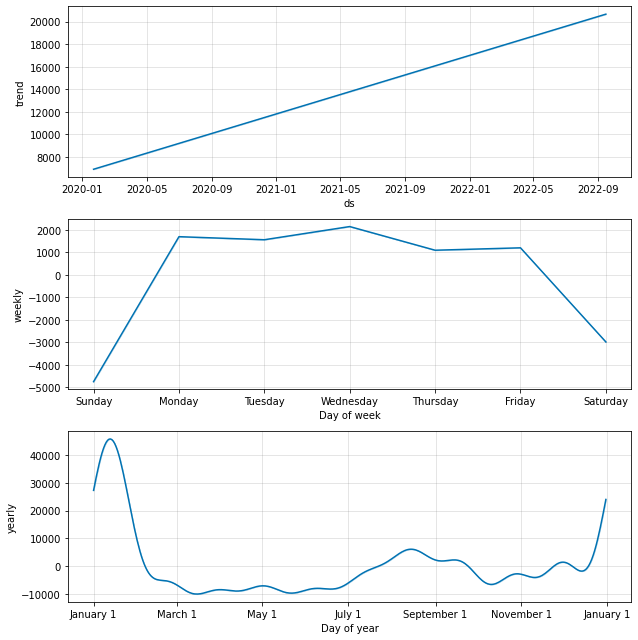

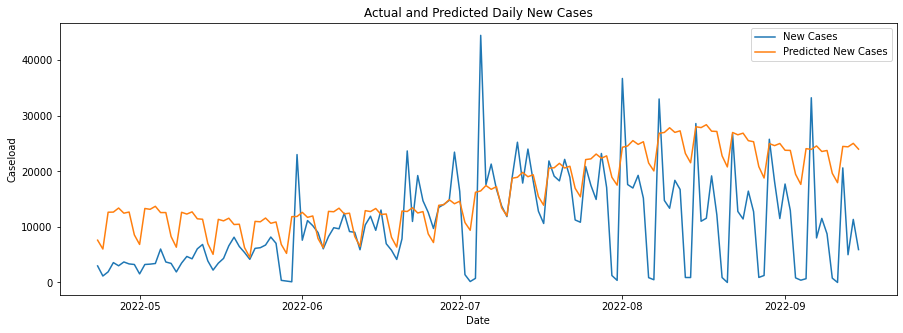

MAE: 7582.127333111219
RMSE: 9868.77772090388
MSE: 97392773.70460875
MASE: 1.715247515337335


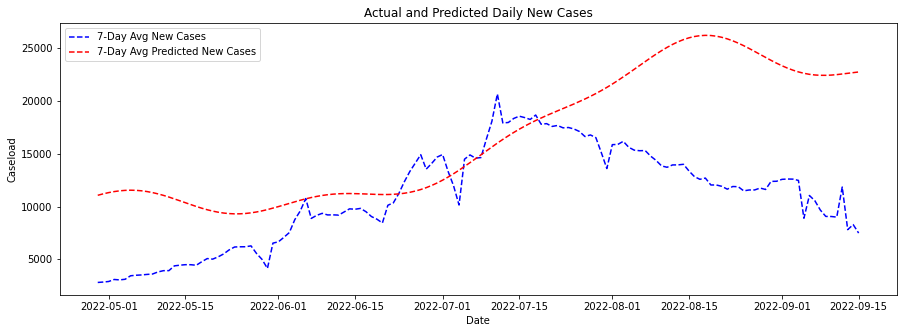

7-Day Avg MAE: 6076.090051881318
7-Day Avg RMSE: 7653.013165186303
7-Day Avg MSE: 58568610.50651487
7-Day Avg MASE: 10.722864453192383
7-Day Avg MAPE: 0.7509908932137347


In [97]:
model, models, forecast_mount, fig1, fig2 = search_prophet(wsc_train, wsc_test, changepoints=[0.0015, .00082, .0006, .0011, .0021], seasonalities=[20, 5.7, .13, 73, 53], n_changepoints_vals=[10, 13, 14, 30])